# k-NN

by Kirill Bykov, Oleg Vlasovets, Ilya

In [1]:
#imports
import pandas as pd #pandas for reading csv file
import numpy as np  #numpy for vectorising
import seaborn as sns
from scipy.spatial import distance_matrix
from tqdm import tqdm
import math
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_MNIST(file_path):
    df = pd.read_csv(file_path, header = None)
    Y = np.array(df[0])
    X = np.array(df.iloc[:,1:])
    return X, Y

def distance(A, B, metric = "euclidean"):
    if metric == "euclidean":
        return np.linalg.norm(A-B)

def first_most_frequent(arr):
    c = 0
    num = arr[0]
    for i in arr:
        amount_times = arr.count(i)
        if amount_times > c:
            c = amount_times
            num = i
    return num

def accuracy(Y_pred, Y_true):
    return np.mean(1 - np.equal(Y_true, Y_pred, dtype=int))

In [4]:
class kNN:
    
    def __init__(self, X_train, Y_train, p = 2):
        self.X_train = X_train/255.
        self.Y_train = Y_train
        self.length = len(X_train)
        self.p = p
        self.inner_distances_calculated = False
        
    def set_minkovsky_parameter(self, p):
        self.p = p
        self.inner_distances_calculated = False
        
    def vote(self, NN):
        n = len(NN)
        votes = np.zeros(n).astype(int)
        for i in range(0, n):
            votes[i] = first_most_frequent([self.Y_train[j] for j in NN[i]])
        return votes
    
    def predict(self, X_test, k):
        X_test = X_test/255.
        n_test = len(X_test)
        D = np.zeros((n_test, self.length))
        NN = np.zeros((n_test,k)).astype(int)
        D = distance_matrix(X_test, self.X_train, self.p)
        for i in range(0, n_test):
            NN[i] = D[i].argsort()[:k]
        return self.vote(NN)
    
    def LOOCV(self, k):
        if not self.inner_distances_calculated:
            print("Calculating distances. This could take some time ...")
            self.inner_distances = distance_matrix(self.X_train, self.X_train, self.p);
            self.inner_NN = np.zeros((self.length,self.length)).astype(int)
            for i in range(0,self.length):
                self.inner_NN[i] = self.inner_distances[i].argsort()
            self.inner_distances_calculated = True

        return self.vote(self.inner_NN[:,1:k+1])
    
#     def LOOCV_big(self, k):
#         if not self.inner_distances_calculated or self.inner_NN.shape[1]<k:
#             print("Calculating distances. This could take some time ...")
#             self.inner_NN = []
#             for i in tqdm(range(self.length)):
#                 D = distance_matrix([self.X_train[i]], self.X_train, self.p);
#                 NN = D[0].argsort()[1:k+1]
#                 self.inner_NN.append(NN)
#             self.inner_NN = np.array(self.inner_NN)
        
#         return self.vote(self.inner_NN[:,:k])

    def LOOCV_big(self, k):
        if not self.inner_distances_calculated or self.inner_NN.shape[1]<k:
            print("Calculating distances. This could take some time ...")
            self.inner_NN = []
            for i in tqdm(range(math.trunc(self.length/500))):
                D = distance_matrix(self.X_train[500*i:500*(i+1)], self.X_train, self.p);
                NN = D.argsort()[1:k+1]
                self.inner_NN.append(NN)
            self.inner_NN = np.array(self.inner_NN)
        
        return self.vote(self.inner_NN[:,:k])

### a)

100%|██████████| 20/20 [22:52<00:00, 76.75s/it]


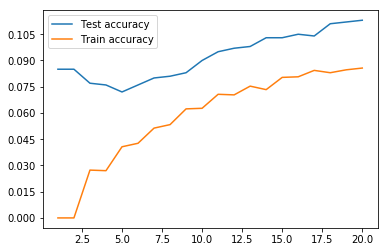

In [4]:
results_test = []
results_train = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
X_test, Y_test = read_MNIST("data/MNIST_test_small.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred_test = classifier.predict(X_test, k)
    results_test.append(accuracy(Y_pred_test, Y_test))
    
    Y_pred_train = classifier.predict(X_train, k)
    results_train.append(accuracy(Y_pred_train, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=results_test, label = 'Test accuracy')
ax = sns.lineplot(x=[i for i in range(1,21)], y=results_train, label = 'Train accuracy')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

Сделайте только картинку получше

## LOOCV

*LOOCV* --- метод, который в первый раз считает расстояния между всеми точками, а затем при различных k использует уже посчитанную матрицу расстояний. Так как в памяти храним все расстояния, работает быстро, но только для маленьгоко датасета

*LOOCV_big* --- метод для работы с большими датасетами, нужно запускать начиная с максимального k, так как на первом запуске держим в памяти только соседей, и не надо пересчитывать это все для маленьких k

### b)

  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


[0.08066666666666666, 0.08066666666666666, 0.073, 0.073, 0.07833333333333334, 0.079, 0.08166666666666667, 0.08233333333333333, 0.08333333333333333, 0.08866666666666667, 0.088, 0.089, 0.09233333333333334, 0.093, 0.09433333333333334, 0.095, 0.09566666666666666, 0.09566666666666666, 0.098, 0.09833333333333333]


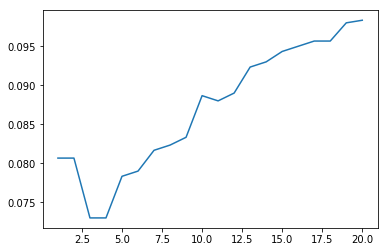

In [5]:
LOOCV_results = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred = classifier.LOOCV(k)
    LOOCV_results.append(accuracy(Y_pred, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_results)
print(LOOCV_results)

### c)

In [8]:
LOOCV_results_Mink = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier = kNN(X_train, Y_train)

for p in tqdm(range(1,16)):
    classifier.set_minkovsky_parameter(int(p))
    for k in range(1,21):
        Y_pred = classifier.LOOCV(k)
        LOOCV_results_Mink.append(accuracy(Y_pred, Y_train))

  0%|          | 0/15 [00:00<?, ?it/s]

Calculating distances. This could take some time ...


  7%|▋         | 1/15 [00:31<07:18, 31.32s/it]

Calculating distances. This could take some time ...


 13%|█▎        | 2/15 [01:07<07:04, 32.65s/it]

Calculating distances. This could take some time ...


 20%|██        | 3/15 [03:00<11:24, 57.03s/it]

Calculating distances. This could take some time ...


 27%|██▋       | 4/15 [04:55<13:37, 74.29s/it]

Calculating distances. This could take some time ...


 33%|███▎      | 5/15 [06:51<14:28, 86.83s/it]

Calculating distances. This could take some time ...


 40%|████      | 6/15 [08:48<14:22, 95.87s/it]

Calculating distances. This could take some time ...


 47%|████▋     | 7/15 [10:44<13:35, 101.88s/it]

Calculating distances. This could take some time ...


 53%|█████▎    | 8/15 [12:41<12:24, 106.43s/it]

Calculating distances. This could take some time ...


 60%|██████    | 9/15 [14:38<10:57, 109.56s/it]

Calculating distances. This could take some time ...


 67%|██████▋   | 10/15 [16:27<09:07, 109.46s/it]

Calculating distances. This could take some time ...


 73%|███████▎  | 11/15 [18:20<07:21, 110.33s/it]

Calculating distances. This could take some time ...


 80%|████████  | 12/15 [20:14<05:35, 111.67s/it]

Calculating distances. This could take some time ...


 87%|████████▋ | 13/15 [22:09<03:45, 112.70s/it]

Calculating distances. This could take some time ...


 93%|█████████▎| 14/15 [24:01<01:52, 112.29s/it]

Calculating distances. This could take some time ...


100%|██████████| 15/15 [25:55<00:00, 112.74s/it]


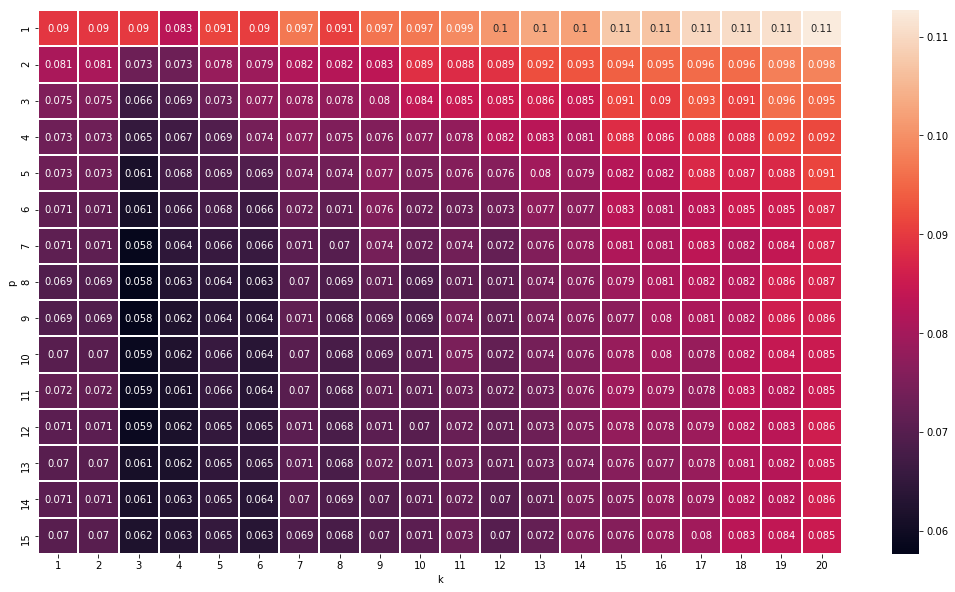

In [9]:
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.heatmap(np.reshape(LOOCV_results_Mink, (15,20)), linewidth=1, annot= True)
plt.xlabel('k')
plt.ylabel('p')
ax.set_xticklabels(range(1,21))
ax.set_yticklabels(range(1,16))
plt.show()

In [ ]:
LOOCV_big_results = []
X_train, Y_train = read_MNIST("data/MNIST_train.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(20,0,-1)):
    Y_pred = classifier.LOOCV_big(k)
    LOOCV_results_full.append(accuracy(Y_pred, Y_train))